In [44]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
!pip install --upgrade scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [46]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.6, 0.6, 0.6), (0.6, 0.6, 0.6))
])

In [47]:
full_dataset = torchvision.datasets.CIFAR10(root='./data', train = True, download = True, transform = transform)
test_dataset_full = torchvision.datasets.CIFAR10(root='./data', train = False, download = True, transform = transform)

In [48]:
def get_subset(dataset, num_samples_per_class=600):
  indices = []
  targets = dataset.targets if hasattr(dataset, 'targets') else dataset.train_labels
  for class_idx in range(10):
    class_indicies = [i for i, label in enumerate(targets) if label == class_idx]
    indices.extend(class_indicies[:num_samples_per_class])
  return torch.utils.data.Subset(dataset, indices)

train_dataset = get_subset(full_dataset, 800)
test_dataset = get_subset(test_dataset_full, 200)

train_indices, val_indices = train_test_split(
    list(range(len(train_dataset))),
    test_size = 0.2,
    stratify = [train_dataset.dataset.targets[i] for i in train_dataset.indices],
    random_state = 42
)

train_subset = torch.utils.data.Subset(train_dataset, train_indices)
val_subset = torch.utils.data.Subset(train_dataset, val_indices)

batch_size = 100
train_loader = torch.utils.data.DataLoader(train_subset, batch_size = batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [49]:
class KNN:
  def __init__(self, k):
    self.k = k
    self.x_train = None
    self.y_train = None

  def fit(self, dataloader):
    images, labels = [], []
    for img, label in tqdm(dataloader, desc="Loading Training Data"):
      images.append(img.view(img.size(0), -1).to(device))
      labels.append(label.to(device))
    self.x_train = torch.cat(images, dim=0)
    self.y_train = torch.cat(labels, dim=0)


  def predict(self, dataloader):
    predictions, true_labels = [], []
    for img, label in tqdm(dataloader, desc="Predicting..."):
      x = img.view(img.size(0), -1).to(device)
      dists = torch.cdist(x, self.x_train)
      _, indicies = torch.topk(dists, self.k, largest=False, dim=1)
      y_pred = torch.mode(self.y_train[indicies], dim = 1)[0]
      predictions.append(y_pred.cpu())
      true_labels.append(label)
    return torch.cat(predictions), torch.cat(true_labels)


  def evaluate(self, dataloader):
    y_pred, y_true = self.predict(dataloader)
    accuracy = accuracy_score(y_true.cpu(), y_pred.cpu())
    report = classification_report(y_true.cpu(), y_pred.cpu(), target_names= classes)
    cm = confusion_matrix(y_true.cpu(), y_pred.cpu())
    return accuracy, report, cm

In [50]:
def cross_validation(k_values, train_loader, val_loader):
  best_k, best_acc = 1, 0
  for k in k_values:
    knn = KNN(k)
    knn.fit(train_loader)
    acc, _, _ = knn.evaluate(val_loader)
    print(f"k={k}: Validation Accuracy = {acc:.4f}")
    if acc > best_acc:
      best_acc = acc
      best_k = k
    return best_k


# k_values = [1, 3, 5, 7, 9]
k_values = [16, 26]
best_k = cross_validation(k_values, train_loader, val_loader)
print(f"\nBest k:{best_k}")



Predicting...: 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]

k=16: Validation Accuracy = 0.2744

Best k:16


Predicting...: 100%|██████████| 20/20 [00:05<00:00,  3.71it/s]



Test Accuracy (k=16): 0.2685

Test Classification Report: 
               precision    recall  f1-score   support

       plane       0.30      0.47      0.36       200
         car       0.59      0.05      0.09       200
        bird       0.19      0.39      0.25       200
         cat       0.36      0.10      0.16       200
        deer       0.18      0.48      0.26       200
         dog       0.37      0.12      0.18       200
        frog       0.26      0.25      0.26       200
       horse       0.52      0.12      0.19       200
        ship       0.37      0.61      0.46       200
       truck       0.73      0.11      0.19       200

    accuracy                           0.27      2000
   macro avg       0.39      0.27      0.24      2000
weighted avg       0.39      0.27      0.24      2000



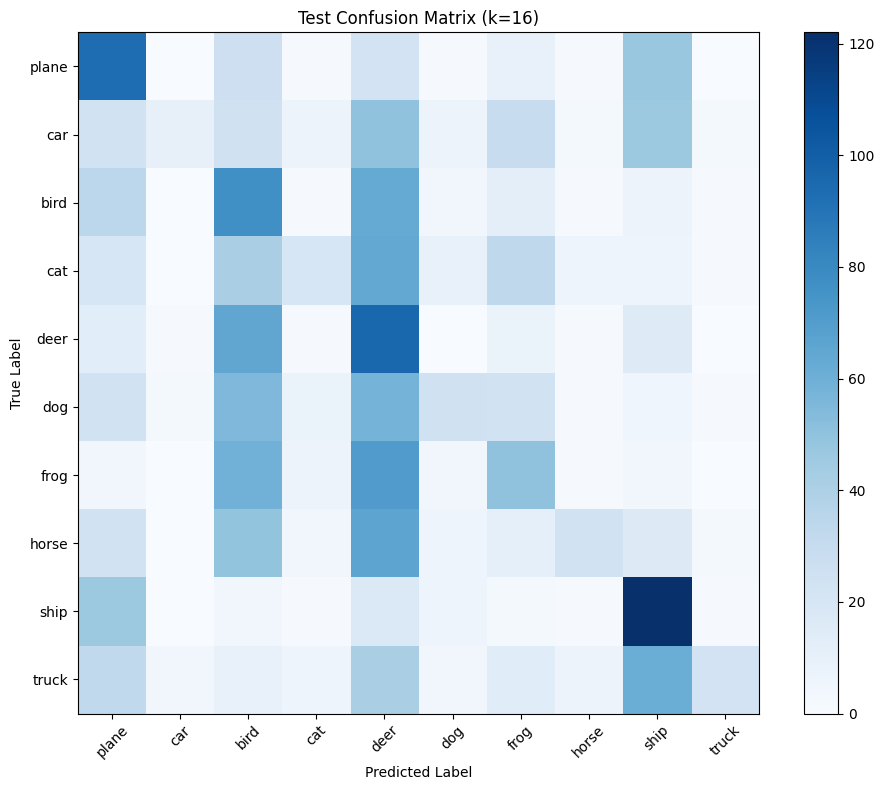

In [51]:
best_knn = KNN(k=best_k)
best_knn.fit(train_loader)

test_accuracy, test_report, test_cm = best_knn.evaluate(test_loader)
print(f"\nTest Accuracy (k={best_k}): {test_accuracy:.4f}")
print("\nTest Classification Report: \n", test_report)


plt.figure(figsize=(10, 8))
plt.imshow(test_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f"Test Confusion Matrix (k={best_k})")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()